In [572]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\brazen\AppData\Local\Temp\ipykernel_14888\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [573]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

import os
from collections import Counter

In [574]:
# # ВАЖНО для Colab: Установка недостающих библиотек
%pip install -q imblearn kaggle

from imblearn.over_sampling import SMOTE

Note: you may need to restart the kernel to use updated packages.


In [575]:
# константы
# ядро для генератора случайных чисел
my_seed = 17
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-v0_8-white')
sns.set_palette("Set1")
# раскомментируйте следующую строку, чтобы посмотреть палитру
sns.color_palette("Set1")

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [576]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))

# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)

# функция, которая строит график важности признаков в модели случайного леса
# источник: https://www.analyseup.com/learn-python-for-data-science/python-rand
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
    inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                hue=fi_df['feature_importance'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

# **Загружаем данные**

Загружаем данные Heart Disease

In [577]:
localDataPath = './data/'
localFileName = 'heart.csv'
localFilePath = os.path.join(localDataPath, localFileName)

!kaggle datasets download -f {localFileName} -p {localDataPath} --unzip fedesoriano/heart-failure-prediction

heart.csv: Skipping, found more recently modified local copy (use --force to force download)


In [578]:
DF_raw = pd.read_csv(localFilePath)
DF_raw

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [579]:
DF_raw.iloc[:, :6].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS
0,40,M,ATA,140,289,0
1,49,F,NAP,160,180,0
2,37,M,ATA,130,283,0
3,48,F,ASY,138,214,0
4,54,M,NAP,150,195,0


In [580]:
DF_raw.iloc[:, 6:12].head()

,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,Normal,172,N,0.0,Up,0
1,Normal,156,N,1.0,Flat,1
2,ST,98,N,0.0,Up,0
3,Normal,108,Y,1.5,Flat,1
4,Normal,122,N,0.0,Up,0


In [581]:
# разделим номинальные и порядковые шкалы
ord_col_names = ['ST_Slope']
nom_col_names = ['Sex', 'RestingECG', 'ChestPainType', 'ExerciseAngina']
cat_col_names = ord_col_names + nom_col_names

# Предварительный анализ данных

## Описательные статистики

Считаем частоты значений категориальных переменных

In [582]:
def display_freq(col):
    col_freq = np.round(DF_raw[col].value_counts(dropna=False) / DF_raw[col].shape[0], 2)
    display(col_freq.sort_index())
    print('Всего уникальных значений: ', col_freq.shape[0])

for col in cat_col_names:
    display_freq(col)
    print()

ST_Slope
Down    0.07
Flat    0.50
Up      0.43
Name: count, dtype: float64

Всего уникальных значений:  3



Sex
F    0.21
M    0.79
Name: count, dtype: float64

Всего уникальных значений:  2



RestingECG
LVH       0.20
Normal    0.60
ST        0.19
Name: count, dtype: float64

Всего уникальных значений:  3



ChestPainType
ASY    0.54
ATA    0.19
NAP    0.22
TA     0.05
Name: count, dtype: float64

Всего уникальных значений:  4



ExerciseAngina
N    0.6
Y    0.4
Name: count, dtype: float64

Всего уникальных значений:  2



In [583]:
display_freq('HeartDisease')

HeartDisease
0    0.45
1    0.55
Name: count, dtype: float64

Всего уникальных значений:  2


In [584]:
# # SMOTE
# sm = SMOTE(random_state=42)
# DF_res = sm.fit_resample()

Выводы по описательным статистикам:
- Пропусков нет
- Наибольшее количество категорий у переменной ChestPainType
- Дисбаланс классов отсутствует

# Распределение предикторов внутри классов по зависимой переменной

In [585]:
for col in DF_raw.columns[:-1]:
    con_tab = pd.crosstab(DF_raw[col], DF_raw['HeartDisease'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.01 :
        print(col, 'и HeartDisease',
        '\nH_0: переменные распределены независимо друг от друга',
        '\nP-значение:', np.around(p, 4))

RestingBP и HeartDisease 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.0143


Сильнее всего вероятность заболевания сердца коррелирована с количеством ударов в минуту в состоянии покоя 

## Перекодировка номинальной и порядковой шкал

In [586]:
# меняем тип столбцов на категориальные
for col in DF_raw.columns[DF_raw.dtypes == 'object'] :
    DF_raw[col] = DF_raw[col].astype('category')

In [587]:
DF_raw.dtypes

Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS            int64
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

Преобразуем показатели номинальной шкалы. Сначала убедимся, что нет пропущенных значений

In [588]:
DF_raw[nom_col_names].isna().sum()

Sex               0
RestingECG        0
ChestPainType     0
ExerciseAngina    0
dtype: int64

In [589]:
one_hot = OneHotEncoder()
recoded = one_hot.fit_transform(DF_raw[nom_col_names]).toarray()
cols = one_hot.get_feature_names_out(nom_col_names)
DF_raw_dummy_nom = pd.DataFrame(recoded, columns=cols)

print(DF_raw_dummy_nom.shape)
DF_raw_dummy_nom.head()

(918, 11)


,Sex_F,Sex_M,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,ExerciseAngina_Y
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Преобразуем показатели порядковой шкалы. Сначала убедимся, что нет пропущенных значений

In [590]:
DF_raw[ord_col_names].isna().sum()

ST_Slope    0
dtype: int64

In [591]:
for col in ord_col_names:
    display_freq(col)
    print

ST_Slope
Down    0.07
Flat    0.50
Up      0.43
Name: count, dtype: float64

Всего уникальных значений:  3


In [592]:
# зададим порядок кодировки
enc_ST_Slope = ['Down', 'Flat', 'Up']

ordinal = OrdinalEncoder(categories=[enc_ST_Slope])

DF_raw_ord = pd.DataFrame(ordinal.fit_transform(DF_raw[ord_col_names]),
                      columns=ord_col_names)
print(DF_raw_ord.shape)
DF_raw_ord.head()

(918, 1)


,ST_Slope
0,2.0
1,1.0
2,2.0
3,1.0
4,2.0


In [593]:
# объединим результаты перекодировки
DF_raw_num = pd.concat([DF_raw.loc[:, DF_raw.dtypes == 'int64'].reset_index(drop=True),
                   DF_raw_dummy_nom, DF_raw_ord], axis=1)

print(DF_raw_num.shape)
DF_raw_num.tail()

(918, 18)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,HeartDisease,Sex_F,Sex_M,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope
913,45,110,264,0,132,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
914,68,144,193,1,141,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
915,57,130,131,0,115,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
916,57,130,236,0,174,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
917,38,138,175,0,173,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0


Отложим 15% наблюдений для прогноза

In [594]:
DF_num = DF_raw_num.sample(frac=0.85, random_state=my_seed)
DF_predict_num = DF_raw_num.drop(DF_num.index)

# Модель дерева

## Дерево на всех признаках

In [595]:
DF_num.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'HeartDisease',
       'Sex_F', 'Sex_M', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope'],
      dtype='object')

In [596]:
X = DF_num.drop(columns=['HeartDisease'])
y = DF_num['HeartDisease']

cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)
tree_full.get_n_leaves()

125

In [597]:
tree_full.get_depth()

13

In [598]:
model_scores = {}

# вспомогоательная функция для хранения результатов
def record_score(model_name, cv_scores):
    if model_name not in model_scores.keys():
        model_scores[model_name] = {}

    model_scores[model_name].update({
        'acc': np.round(np.mean(cv_scores), 3)
    })

def display_score(model_name):
    if model_name not in model_scores.keys():
        print('Нет такой модели')
    
    score = model_scores[model_name]
    print(f"Model \'{model_name}\' cross-val Acc: {score['acc']}")

In [599]:
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

record_score('one_tree', cv)
display_score('one_tree')

Model 'one_tree' cross-val Acc: 0.797


## Дерево с обрезкой ветвей

In [600]:
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Total alphas:', len(ccp_alphas))
print('First 5 alphas\' entropy:', *np.round(impurities[:5], 3))

Total alphas: 72
First 5 alphas' entropy: 0.0 0.005 0.009 0.013 0.017


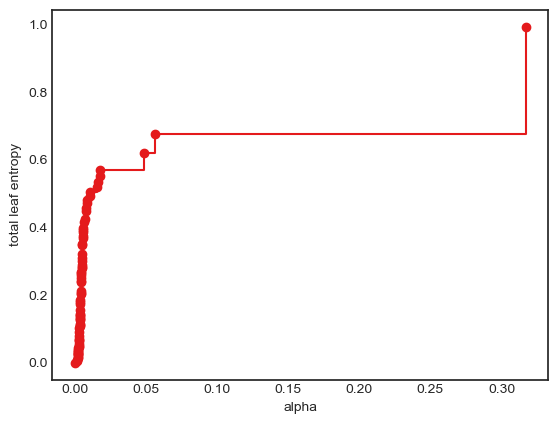

In [601]:
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel('alpha')
plt.ylabel('total leaf entropy')
plt.show()

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_seed)
clfs = []

tic = time.perf_counter()

# построим деревья для всех значений альфа
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

toc = time.perf_counter()
print(f'Time elapsed: {toc-tic:-.2f}')

Time elapsed: 0.33


In [603]:
tic = time.perf_counter()

# извлечем глубину и расчитаем точность
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

toc = time.perf_counter()
print(f'Time elapsed: {toc-tic:-.2f}')

Time elapsed: 0.34


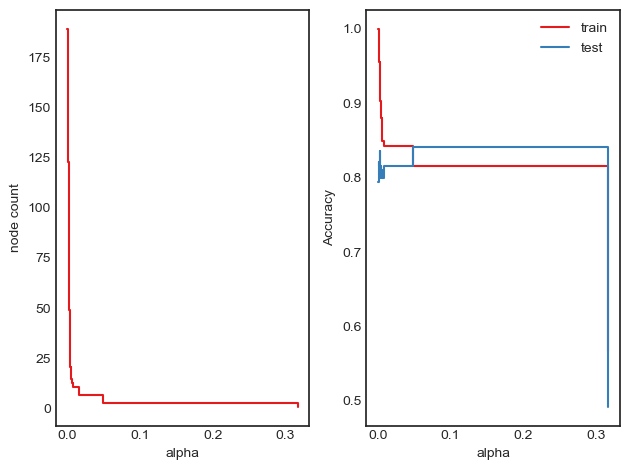

In [604]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle='steps-post')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('node count')

ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle='steps-post')
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle='steps-post')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='upper right')
fig.tight_layout()

Находим оптимальный размер дерева по макс $Accuracy$ на тесте

In [605]:
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                     scoring='accuracy')

print(f'Optimal alpha: {round(ccp_alphas[opt_nodes_num], 3)}')
print(f'Optimal node count: {opt_nodes_num}')
print(f'Test Accuracy: {round(max(test_scores), 3)}')
record_score('pruned_tree', cv)
display_score('pruned_tree')

Optimal alpha: 0.002
Optimal node count: 3
Test Accuracy: 0.841
Model 'pruned_tree' cross-val Acc: 0.809


In [606]:
clfs[opt_nodes_num].get_n_leaves()

49

In [607]:
clfs[opt_nodes_num].get_depth()

9

In [608]:
print([i for i in node_counts if i < 20])

[19, 19, 19, 19, 19, 19, 17, 17, 17, 17, 15, 13, 13, 13, 11, 11, 11, 11, 11, 11, 7, 7, 7, 7, 3, 3, 1]


Node count: 11
Test Accuracy: 0.815


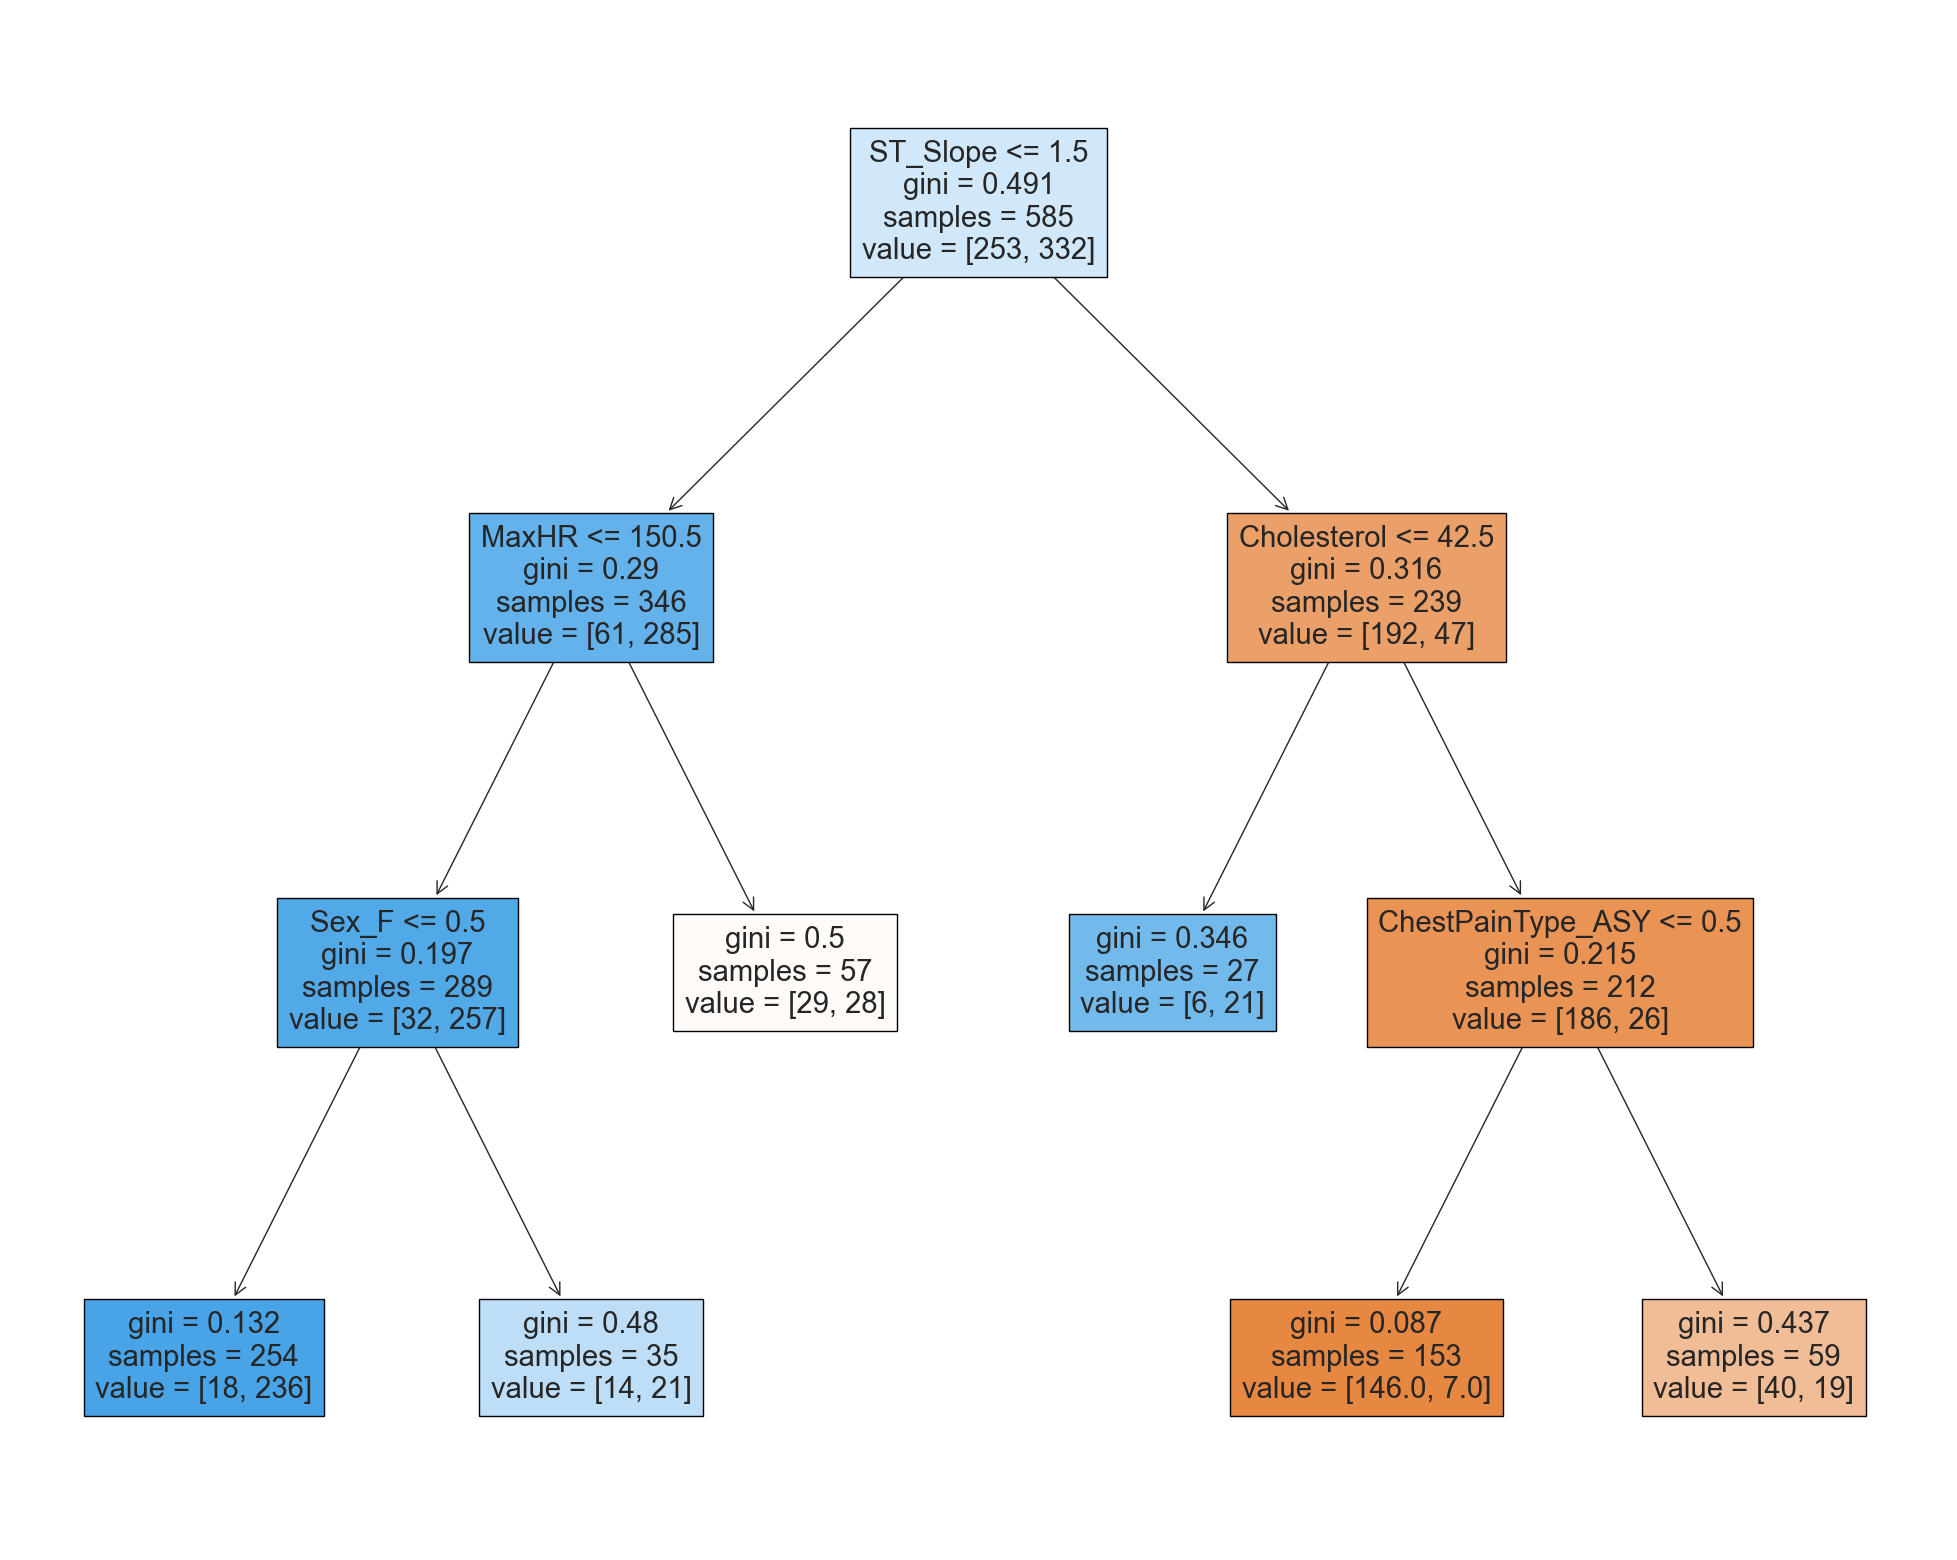

In [609]:
nodes_num = 11
print(f'Node count: {nodes_num}')
print('Test Accuracy: {0}'.format(
    np.around(test_scores[node_counts.index(nodes_num)], 3)
))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], filled=True, 
          feature_names=X.columns)

In [610]:
viz = export_text(clfs[node_counts.index(nodes_num)],
                  feature_names=list(X.columns))
print(viz)

|--- ST_Slope <= 1.50
|   |--- MaxHR <= 150.50
|   |   |--- Sex_F <= 0.50
|   |   |   |--- class: 1
|   |   |--- Sex_F >  0.50
|   |   |   |--- class: 1
|   |--- MaxHR >  150.50
|   |   |--- class: 0
|--- ST_Slope >  1.50
|   |--- Cholesterol <= 42.50
|   |   |--- class: 1
|   |--- Cholesterol >  42.50
|   |   |--- ChestPainType_ASY <= 0.50
|   |   |   |--- class: 0
|   |   |--- ChestPainType_ASY >  0.50
|   |   |   |--- class: 0



# Случайный лес

Подберем оптимальные гиперпараметры - количество деревьев $B$ и количество признаков для построения отдельного дерева $m$ - с помощью перебора по сетке. В качестве возможных значений $m$ возьмем равнноотстоящие значения от $\sqrt p$ до $p$ 

In [611]:
p = X.shape[1]
ms = np.around(np.linspace(np.sqrt(p), p, 7, dtype=int))
ms

array([ 4,  6,  8, 10, 12, 14, 17])

In [612]:
param_grid = {
    'n_estimators': list(range(10, 80, 10)),
    'max_features': ms
    }

tic = time.perf_counter()
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
toc = time.perf_counter()

print(f'Time elapsed: {toc-tic:0.2f} sec')

Time elapsed: 23.72 sec


In [613]:
print('Best model Acc: {},'.format(np.around(random_forest.best_score_, 3)))
print('Best model tree count \'B\': {}'.format(
    random_forest.best_estimator_.get_params()['n_estimators']
))
print('Best model max predictors per split \'m\': {}'.format(
    random_forest.best_estimator_.get_params()['max_features']
))

record_score('random_forest', random_forest.best_score_)

Best model Acc: 0.873,
Best model tree count 'B': 40
Best model max predictors per split 'm': 4


Оценим важность предикторов

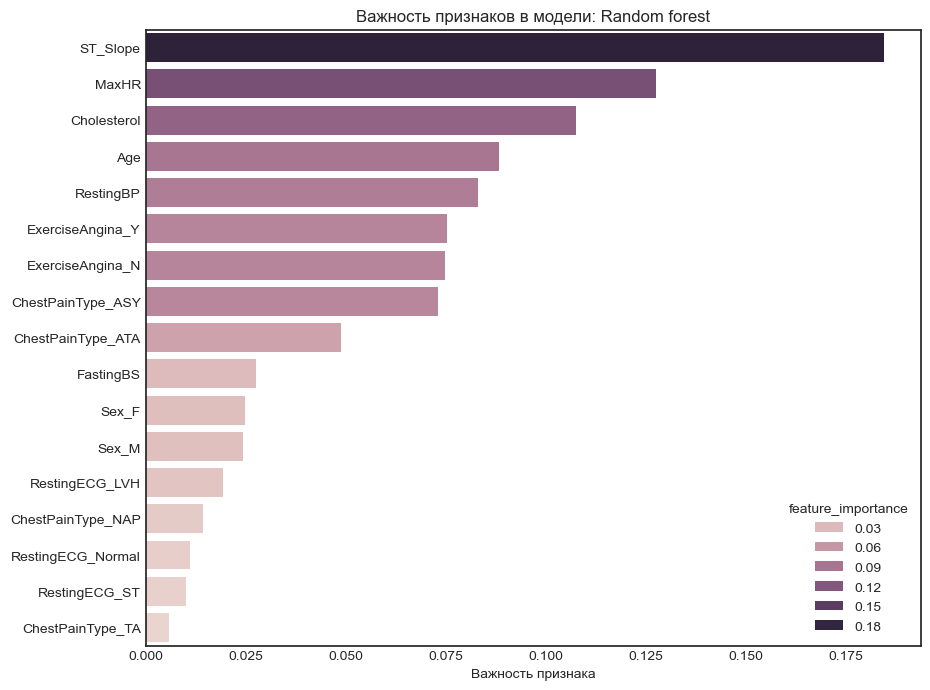

In [614]:
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Random forest')

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точности всех моделей

In [615]:
pd.DataFrame.from_dict(model_scores, orient='index') \
    .sort_values(by='acc',ascending=False)

,acc
random_forest,0.873
pruned_tree,0.809
one_tree,0.797


Случайный лес показал лучшее качество. Сделаем прогноз на отложенные наблюдения

In [616]:
X_pred = DF_predict_num.drop(['HeartDisease'], axis=1)
y_hat = random_forest.best_estimator_.predict(X_pred)
print(classification_report(DF_predict_num['HeartDisease'], y_hat))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        58
           1       0.89      0.85      0.87        80

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138

